# Graph Neural Networks Implementation

In [1]:
import torch
torch.__version__

'2.3.1+cu121'

In [2]:
%pip install torch-geometric \
  torch-sparse \
  torch-scatter \
  torch-cluster \
  pyg-lib \
  -f https://data.pyg.org/whl/torch-{torch.__version__}.html

Looking in links: https://data.pyg.org/whl/torch-2.3.1+cu121.html
Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv, SAGEConv, GATConv

import warnings
warnings.filterwarnings('ignore')

/home/kubwa/anaconda3/envs/gnn/lib/python3.11/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /home/kubwa/anaconda3/envs/gnn/lib/python3.11/site-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSsb
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/home/kubwa/anaconda3/envs/gnn/lib/python3.11/site-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /home/kubwa/anaconda3/envs/gnn/lib/python3.11/site-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSsb
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


## Load and Explore Dataset

In [5]:
# Load the Cora dataset
dataset = Planetoid(root='dataset/Cora', name='Cora')

# Get the graph data
data = dataset[0]

# Print dataset statistics
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Number of features: {data.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Number of nodes: 2708
Number of edges: 10556
Number of features: 1433
Number of classes: 7


## Graph Convolutional Network (GCN)

In [6]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

## GraphSAGE Implementation

In [7]:
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

## Graph Attention Network (GAT)

In [8]:
class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=8, dropout=0.6):
        super(GAT, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1, dropout=dropout)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

## Visualize Function

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(8,8))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

## Training and Evaluation Function

In [15]:
def train_and_evaluate(model, data, epochs=200):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    criterion = torch.nn.NLLLoss()
    
    # Training
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 50 == 0:
            print(f'Epoch {epoch+1:03d}, Loss: {loss.item():.4f}')
    
    # Evaluation
    model.eval()
    _, pred = model(data.x, data.edge_index).max(dim=1)
    correct = float(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
    accuracy = correct / data.test_mask.sum().item()
    print(f'Test Accuracy: {accuracy:.4f}')
    
    out = model(data.x, data.edge_index)
    visualize(out, color=data.y)

    
    return accuracy

## Train and Compare Models

Training GCN...
Epoch 050, Loss: 0.0675
Epoch 100, Loss: 0.0426
Epoch 150, Loss: 0.0255
Epoch 200, Loss: 0.0211
Test Accuracy: 0.8010


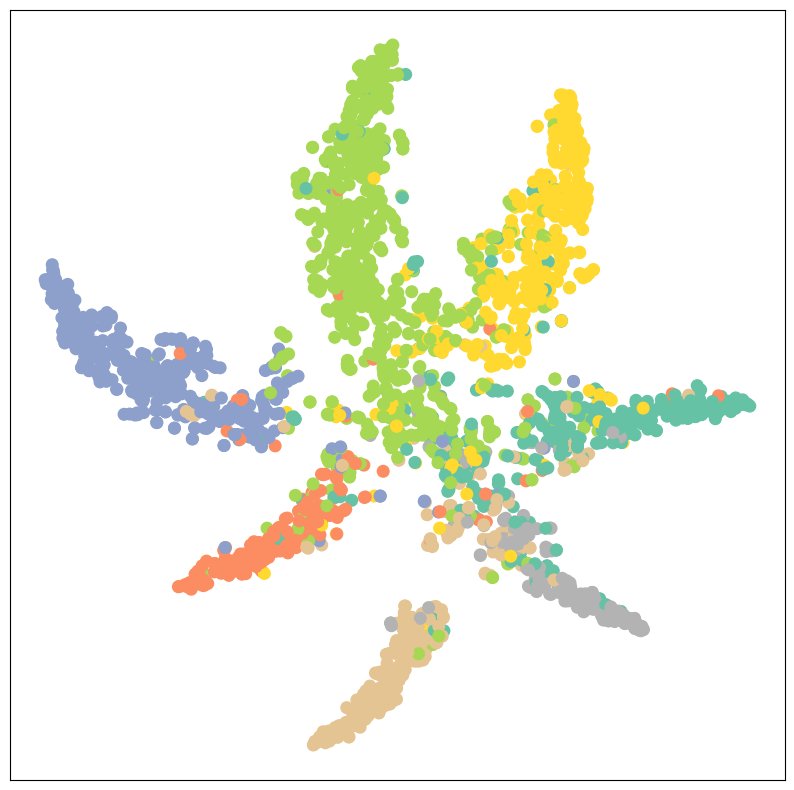


Training GraphSAGE...
Epoch 050, Loss: 0.0162
Epoch 100, Loss: 0.0267
Epoch 150, Loss: 0.0107
Epoch 200, Loss: 0.0129
Test Accuracy: 0.7880


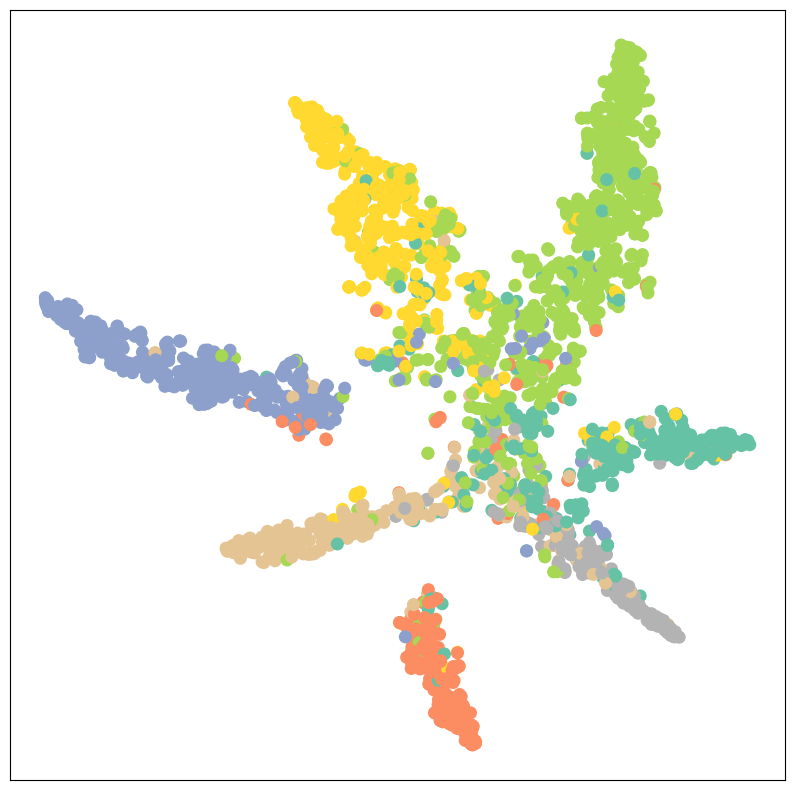


Training GAT...
Epoch 050, Loss: 0.3248
Epoch 100, Loss: 0.2717
Epoch 150, Loss: 0.2874
Epoch 200, Loss: 0.4423
Test Accuracy: 0.7950


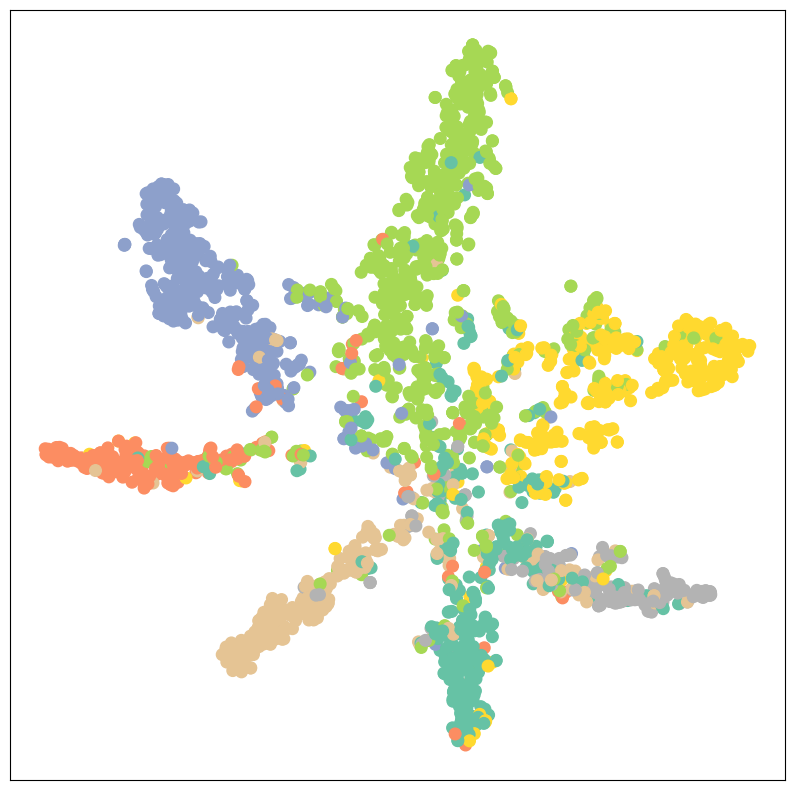


Final Results:
GCN Accuracy: 0.8010
GraphSAGE Accuracy: 0.7880
GAT Accuracy: 0.7950


In [16]:
# Model parameters
in_channels = dataset.num_node_features
hidden_channels = 16
out_channels = dataset.num_classes

# Initialize models
gcn_model = GCN(in_channels, hidden_channels, out_channels)
sage_model = GraphSAGE(in_channels, hidden_channels, out_channels)
gat_model = GAT(in_channels, hidden_channels, out_channels)

# Train and evaluate each model
print("Training GCN...")
gcn_acc = train_and_evaluate(gcn_model, data)

print("\nTraining GraphSAGE...")
sage_acc = train_and_evaluate(sage_model, data)

print("\nTraining GAT...")
gat_acc = train_and_evaluate(gat_model, data)

# Compare results
print("\nFinal Results:")
print(f"GCN Accuracy: {gcn_acc:.4f}")
print(f"GraphSAGE Accuracy: {sage_acc:.4f}")
print(f"GAT Accuracy: {gat_acc:.4f}")

## Explainer Visualization

Type of Model: *GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


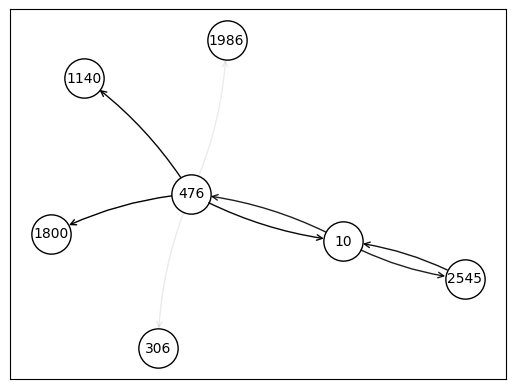

Type of Model: *GraphSAGE(
  (conv1): SAGEConv(1433, 16, aggr=mean)
  (conv2): SAGEConv(16, 7, aggr=mean)
)


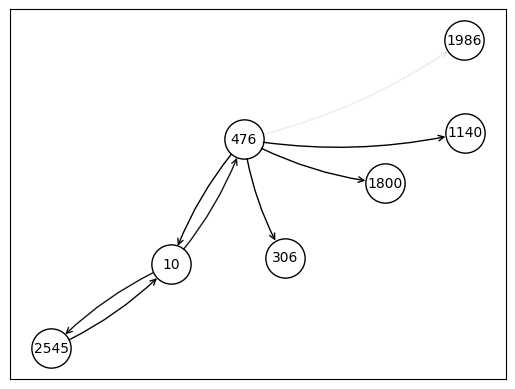

Type of Model: *GAT(
  (conv1): GATConv(1433, 16, heads=8)
  (conv2): GATConv(128, 7, heads=1)
)


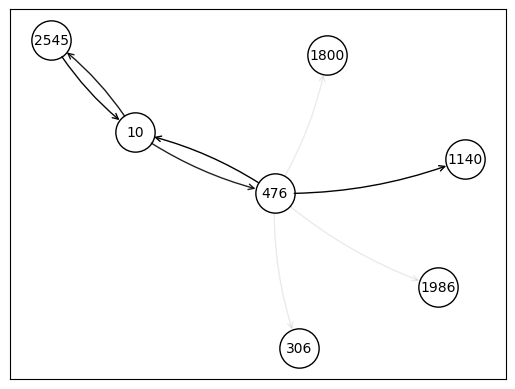

In [17]:
from torch_geometric.explain import Explainer, GNNExplainer

for i in [gcn_model, sage_model, gat_model]:
    explainer = Explainer(
        model=i,
        algorithm=GNNExplainer(epochs=200),
        explanation_type='model',
        node_mask_type='attributes',
        edge_mask_type='object',
        model_config=dict(
            mode='multiclass_classification',
            task_level='node',
            return_type='log_probs',
        ),
    )
    node_index = 10
    explanation = explainer(
        data.x, 
        data.edge_index, 
        index=node_index
    )
    print(f'Type of Model: *{i}')
    explanation.visualize_graph()